# North Carolina - Data Management

## Import the Required Packages

In [1]:
# For working with graphs
import networkx as nx
# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrychain
import gerrychain   
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd

# Other necessary packages
import random
import maup
maup.progress.enabled = True

## Initial Plan

In [2]:
nc_init_gdf = gpd.read_file("SL 2022-3 Congress - Shapefile/SL 2022-3.shp")

In [3]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
nc_init_gdf

,DISTRICT,PL20AA_TOT,geometry
0,1,745671,"POLYGON ((718069.297 180220.738, 718053.924 18..."
1,10,745670,"POLYGON ((340493.663 243808.137, 340446.359 24..."
2,11,745671,"POLYGON ((339228.332 163474.331, 339228.113 16..."
3,12,745671,"POLYGON ((468456.167 162883.712, 468401.813 16..."
4,13,745670,"POLYGON ((636002.879 196325.646, 635999.876 19..."
...,...,...,...
9,5,745671,"POLYGON ((517601.086 310274.626, 517607.265 31..."
10,6,745670,"POLYGON ((545636.912 283232.858, 545796.928 28..."
11,7,745671,"POLYGON ((686660.679 67662.690, 686719.901 676..."
12,8,745670,"POLYGON ((516574.269 278622.948, 516635.357 27..."


## Interim Plan

In [4]:
nc_temp_gdf = gpd.read_file("2022 Interim Congressional - Shapefile/Interim Congressional.shp")

In [5]:
nc_temp_gdf

,DISTRICT,PL20AA_TOT,geometry
0,1,745670,"POLYGON ((748019.999 187054.611, 747998.837 18..."
1,10,745670,"POLYGON ((353671.775 206087.462, 353661.231 20..."
2,11,745671,"POLYGON ((339228.332 163474.331, 339228.113 16..."
3,12,745671,"POLYGON ((464579.507 173485.575, 464573.033 17..."
4,13,745670,"POLYGON ((672671.439 170786.652, 672669.897 17..."
...,...,...,...
9,5,745670,"POLYGON ((344151.224 249103.478, 344130.159 24..."
10,6,745670,"POLYGON ((517601.086 310274.626, 517607.265 31..."
11,7,745671,"POLYGON ((655804.246 122826.939, 655800.725 12..."
12,8,745671,"POLYGON ((552519.358 122804.861, 552507.356 12..."


# 2023 Plan

In [6]:
nc_23_gdf = gpd.read_file("SL 2023-145 Congress - Shapefile/SL 2023-145.shp")

In [7]:
nc_23_gdf

,DISTRICT,PL20AA_TOT,geometry
0,1,745670,"POLYGON ((905355.004 281686.885, 901742.905 28..."
1,10,745670,"POLYGON ((395888.414 226383.013, 395922.249 22..."
2,11,745670,"POLYGON ((304252.990 165004.799, 304247.069 16..."
3,12,745670,"POLYGON ((447279.463 154364.037, 447275.406 15..."
4,13,745670,"POLYGON ((654887.670 269155.323, 654905.776 26..."
...,...,...,...
9,5,745671,"POLYGON ((356422.214 248959.425, 356425.913 24..."
10,6,745671,"POLYGON ((506669.938 278879.654, 506675.688 27..."
11,7,745671,"POLYGON ((690746.724 108164.428, 690757.715 10..."
12,8,745671,"POLYGON ((599592.486 64450.932, 599044.660 650..."


## Add the Congressional Districting Plans to the Voting Precinct Data

In [9]:
# Import the 2022 General Election Voting Data
nc_data_gdf = gpd.read_file("nc_gen_22_st_prec/nc_gen_22_st_prec.shp")

In [10]:
nc_data_gdf.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'COUNTYNM', 'PRECINCT', 'G22USSDBEA',
       'G22USSGHOH', 'G22USSLBRA', 'G22USSOWRI', 'G22USSRBUD', 'GSSC03DINM',
       'GSSC03RDIE', 'GSSC05DERV', 'GSSC05RALL', 'GSAC08DTHO', 'GSAC08RFLO',
       'GSAC09DSAL', 'GSAC09RSTR', 'GSAC10DADA', 'GSAC10RTYS', 'GSAC11DJAC',
       'GSAC11RSTA', 'geometry'],
      dtype='object')

In [11]:
# List of specific columns to keep
columns_to_keep = ["UNIQUE_ID", 'COUNTYFP', 'COUNTYNM', 'PRECINCT', 'geometry', 'G22USSDBEA', 'G22USSRBUD']

# Filter the GeoDataFrame
nc_data_gdf = nc_data_gdf[columns_to_keep]

# Check that we've kept the right stuff
nc_data_gdf

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,geometry,G22USSDBEA,G22USSRBUD
0,BURKE---0001,23,BURKE,0001,"POLYGON ((1233595.464 737538.312, 1233589.172 ...",437,1081
1,STANLY---0003,167,STANLY,0003,"POLYGON ((1644857.853 584760.831, 1644768.728 ...",503,646
2,BURKE---0003,23,BURKE,0003,"POLYGON ((1220715.101 726879.358, 1220723.026 ...",129,492
3,STANLY---0007,167,STANLY,0007,"POLYGON ((1650578.509 584607.573, 1650484.945 ...",379,709
4,STANLY---0008,167,STANLY,0008,"POLYGON ((1646657.855 579294.538, 1646677.799 ...",478,79
...,...,...,...,...,...,...,...
2650,ORANGE---WESTWOOD,135,ORANGE,WESTWOOD,"POLYGON ((1980358.648 779536.674, 1980323.701 ...",1358,97
2651,ALEXANDER---W,3,ALEXANDER,W,"POLYGON ((1328877.683 764648.104, 1328959.697 ...",207,920
2652,LENOIR---W,107,LENOIR,W,"POLYGON ((2419504.837 485228.828, 2419439.358 ...",93,544
2653,HAYWOOD---WAYNESVILLE WEST,87,HAYWOOD,WAYNESVILLE WEST,"POLYGON ((808739.181 660103.212, 808721.741 66...",379,504


In [ ]:
# This is how we assign the precincts to congressional districts

# Initial Plan
precincts_to_districts_init_assignment = maup.assign(nc_data_gdf.geometry, nc_init_gdf.geometry)

# Initial Plan - Alternative
precincts_to_districts_temp_assignment = maup.assign(nc_data_gdf.geometry, nc_tep_gdf.geometry)

# Revised Plan
precincts_to_districts_23_assignment = maup.assign(nc_data_gdf.geometry, nc_23_gdf.geometry)


TypeError: the source and target geometries must have the same CRS. EPSG:2264 EPSG:32119

In [ ]:
# Now, we need to assign each precinct their congressional district - we should be able to do this by adding a column
nc_data_gdf["OriginalPlan"] = precincts_to_districts_init_assignment
nc_data_gdf["TempPlan"] = precincts_to_districts_temp_assignment
nc_data_gdf["RevisedPlan"] = precincts_to_districts_23_assignment

nc_data_gdf

NameError: name 'precincts_to_districts_init_assignment' is not defined

## Joining the Census Data with Precinct Voting Data & Congressional Districts

In [ ]:
# Import the Census data, which is in a .csv format
nc_demographic_blocks = pd.read_csv("DECENNIALPL2020.P1_2024-12-02T141801/DECENNIALPL2020.P1-Data.csv")
print(nc_demographic_blocks.columns)

Index(['GEO_ID', 'NAME', 'P1_001N', 'P1_002N', 'P1_003N', 'P1_004N', 'P1_005N',
       'P1_006N', 'P1_007N', 'P1_008N', 'P1_009N', 'P1_010N', 'P1_011N',
       'P1_012N', 'P1_013N', 'P1_014N', 'P1_015N', 'P1_016N', 'P1_017N',
       'P1_018N', 'P1_019N', 'P1_020N', 'P1_021N', 'P1_022N', 'P1_023N',
       'P1_024N', 'P1_025N', 'P1_026N', 'P1_027N', 'P1_028N', 'P1_029N',
       'P1_030N', 'P1_031N', 'P1_032N', 'P1_033N', 'P1_034N', 'P1_035N',
       'P1_036N', 'P1_037N', 'P1_038N', 'P1_039N', 'P1_040N', 'P1_041N',
       'P1_042N', 'P1_043N', 'P1_044N', 'P1_045N', 'P1_046N', 'P1_047N',
       'P1_048N', 'P1_049N', 'P1_050N', 'P1_051N', 'P1_052N', 'P1_053N',
       'P1_054N', 'P1_055N', 'P1_056N', 'P1_057N', 'P1_058N', 'P1_059N',
       'P1_060N', 'P1_061N', 'P1_062N', 'P1_063N', 'P1_064N', 'P1_065N',
       'P1_066N', 'P1_067N', 'P1_068N', 'P1_069N', 'P1_070N', 'P1_071N',
       'Unnamed: 73'],
      dtype='object')


/var/folders/7_/ynn6zkss3sjb5nkrscffqq500000gn/T/ipykernel_55435/3391662152.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  nc_demographic_blocks = pd.read_csv("DECENNIALPL2020.P1_2024-12-02T141801/DECENNIALPL2020.P1-Data.csv")


In [ ]:
# We will only analyze people that identify as one specific race, so we can get rid of the columns we don't need

# List of specific columns to keep
filtered_columns = ['GEO_ID', 'NAME', 'P1_001N', 'P1_002N', 'P1_003N', "P1_004N", "P1_005N", "P1_006N", "P1_007N", "P1_008N"]

# Filter the GeoDataFrame
nc_demographic_blocks = nc_demographic_blocks[filtered_columns]

# Check that we've kept the right stuff
nc_demographic_blocks

,GEO_ID,NAME,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,Geography,Geographic Area Name,!!Total:,!!Total:!!Population of one race:,!!Total:!!Population of one race:!!White alone,!!Total:!!Population of one race:!!Black or A...,!!Total:!!Population of one race:!!American I...,!!Total:!!Population of one race:!!Asian alone,!!Total:!!Population of one race:!!Native Haw...,!!Total:!!Population of one race:!!Some Other...
1,1000000US370010201001000,"Block 1000, Block Group 1, Census Tract 201, A...",0,0,0,0,0,0,0,0
2,1000000US370010201001001,"Block 1001, Block Group 1, Census Tract 201, A...",34,33,28,5,0,0,0,0
3,1000000US370010201001002,"Block 1002, Block Group 1, Census Tract 201, A...",30,23,14,8,0,0,0,1
4,1000000US370010201001003,"Block 1003, Block Group 1, Census Tract 201, A...",34,33,22,3,0,2,0,6
...,...,...,...,...,...,...,...,...,...,...
236634,1000000US371999604002130,"Block 2130, Block Group 2, Census Tract 9604, ...",7,3,0,1,0,0,0,2
236635,1000000US371999604002131,"Block 2131, Block Group 2, Census Tract 9604, ...",7,7,6,1,0,0,0,0
236636,1000000US371999604002132,"Block 2132, Block Group 2, Census Tract 9604, ...",8,8,7,0,0,1,0,0
236637,1000000US371999604002133,"Block 2133, Block Group 2, Census Tract 9604, ...",10,9,9,0,0,0,0,0


In [ ]:
# Import the shapefile block data
nc_block_gdf = gpd.read_file("tl_2022_nc_tabblock20/tl_2022_37_tabblock20.shp")

In [ ]:
nc_block_gdf

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,...,INTPTLAT20,INTPTLON20,HOUSING20,POP20,geometry
0,37,113,970200,1028,371139702001028,...,+35.2219865,-083.4257985,0,0,"POLYGON ((-83.42925 35.22443, -83.42921 35.224..."
1,37,113,970502,1063,371139705021063,...,+35.0422689,-083.1994568,0,0,"POLYGON ((-83.19980 35.04242, -83.19972 35.042..."
2,37,113,970502,1070,371139705021070,...,+35.0564903,-083.1573224,0,0,"POLYGON ((-83.15848 35.05691, -83.15812 35.056..."
3,37,113,970501,1012,371139705011012,...,+35.0702737,-083.2163238,8,4,"POLYGON ((-83.22020 35.06493, -83.22018 35.064..."
4,37,113,970501,1066,371139705011066,...,+35.0518322,-083.1979538,1,6,"POLYGON ((-83.19830 35.05229, -83.19826 35.052..."
...,...,...,...,...,...,...,...,...,...,...,...
236633,37,189,920701,1041,371899207011041,...,+36.2448698,-081.5369848,5,8,"POLYGON ((-81.54173 36.24556, -81.53447 36.246..."
236634,37,189,920800,1069,371899208001069,...,+36.1233877,-081.6608360,5,7,"POLYGON ((-81.66156 36.12376, -81.66155 36.123..."
236635,37,189,920601,3012,371899206013012,...,+36.1861201,-081.6716732,0,0,"POLYGON ((-81.67194 36.18631, -81.67180 36.186..."
236636,37,189,920601,3015,371899206013015,...,+36.1877400,-081.6713422,0,0,"POLYGON ((-81.67160 36.18937, -81.67157 36.189..."


In [ ]:
# We now need to combine the shapefil block data with the Census data
# We can join on GEO_ID, but need to rename column of shapefile and cut down the geoid in csv
nc_block_gdf['GEO_ID'] = nc_block_gdf['GEOID20']
nc_demographic_blocks["GEO_ID"] = nc_demographic_blocks["GEO_ID"].str[9:]

In [ ]:

# Confirm that we have a matching column to join on! 
# This is just a test of one specific GEO_ID, but if it works most likely everything else worked
if ((nc_block_gdf["GEO_ID"] == "371999604002134").any()):
    print("Found")
if ((nc_demographic_blocks["GEO_ID"] == "371999604002134").any()):
    print("Found")
else:
    print("Not found")

Found
Found


In [ ]:
# Now, we can actually do the join!
nc_block_gdf = nc_block_gdf.merge(nc_demographic_blocks, on = ["GEO_ID"], how = "left")
nc_block_gdf
# Yay, it's joined!

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,...,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,37,113,970200,1028,371139702001028,...,0,0,0,0,0
1,37,113,970502,1063,371139705021063,...,0,0,0,0,0
2,37,113,970502,1070,371139705021070,...,0,0,0,0,0
3,37,113,970501,1012,371139705011012,...,0,0,0,0,1
4,37,113,970501,1066,371139705011066,...,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...
236633,37,189,920701,1041,371899207011041,...,0,0,0,0,0
236634,37,189,920800,1069,371899208001069,...,0,0,0,0,0
236635,37,189,920601,3012,371899206013012,...,0,0,0,0,0
236636,37,189,920601,3015,371899206013015,...,0,0,0,0,0


In [ ]:
# We now need to agregate the block data up to the precinct data
pop_cols = ['P1_001N', 'P1_002N', 'P1_003N', "P1_004N", "P1_005N", "P1_006N", "P1_007N", "P1_008N"]

# How blocks are inputted into the precinct shapefile dataframe
blocks_to_precincts_assignment = maup.assign(nc_block_gdf.geometry, nc_data_gdf.geometry)

# We need to get all the data types of P1 to ints
for item in pop_cols:
    nc_block_gdf[item] = pd.to_numeric(nc_block_gdf[item])

nc_data_gdf[pop_cols] = nc_block_gdf[pop_cols].groupby(blocks_to_precincts_assignment).sum()


TypeError: the source and target geometries must have the same CRS. EPSG:4269 EPSG:2264

In [ ]:
nc_data_gdf[pop_cols].head()

print(nc_block_gdf[pop_cols].sum())

print(nc_data_gdf[pop_cols].sum())

KeyError: "None of [Index(['P1_001N', 'P1_002N', 'P1_003N', 'P1_004N', 'P1_005N', 'P1_006N',\n       'P1_007N', 'P1_008N'],\n      dtype='object')] are in the [columns]"

In [ ]:
nc_data_gdf

## Let's save the above work to a shapefile so we don't have to deal with it later...

In [ ]:
nc_data_gdf.to_file("NorthCarolina_precincts_with_data.shp")

## Finally, Check that nothing screwed up

In [ ]:
# Plot the black population percentage by precincts
nc_data_gdf['b_frac'] = pd.to_numeric(nc_data_gdf['P1_004N'])/pd.to_numeric(nc_data_gdf['P1_001N'])
nc_data_gdf.plot(column = 'b_frac', missing_kwds = {"color":"grey"}, legend=True)


KeyError: 'P1_004N'

<Axes: >

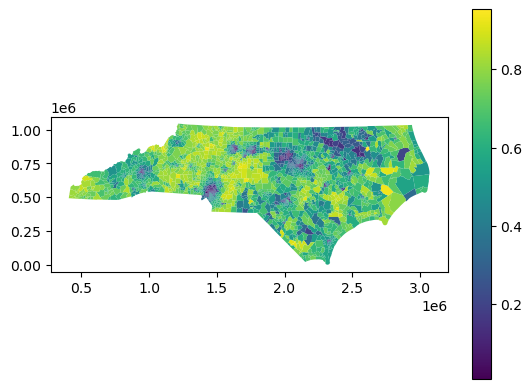

In [ ]:
# Plot the senate republican votes by precincts
nc_data_gdf['senate_r_perc'] = pd.to_numeric(nc_data_gdf['G22USSRBUD'])/pd.to_numeric(nc_data_gdf["G22USSDBEA"] + nc_data_gdf['G22USSRBUD'])
nc_data_gdf.plot(column = 'senate_r_perc', missing_kwds = {"color":"grey"}, legend=True)
